## 2 Neural Networks

In this section we are going to look at networks of neurons. To best understad how this enables us to do amazing things we also have to learn about matrix operations and partial differentiation. We are going to combine these two mathematical consepts to understand the backpropagation algorithm and how we can train our network. Last but not least, we are going to look at a practical example and use what we have learned to classify images of cats!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from testCases_v2 import *
from lr_utils import load_dataset
%matplotlib inline

### 2.1 Network of Neurons

In our perceptron we have seen how it is a simplification of the real neuron. We first going to do some upgrades to it! We are now going to swich out the step function and the threshold with some new ideas.

Remember that weird s-like Sigmoid function we implemented earlier? This function is sometimes also called a **logistic function**. We'll use this when making our own neural network. It's smoother than the cold, hard step function, and this makes it more natural and realistic. Nature rarely has cold hard edges!

![](Images/sigmoid_smoth.png)


Let’s get back to neurons. Remember how we took multiple inputs in the perceptron? This actually reflects how real neurons work. The real neurons take input from all their predicesors and combines the signal. The following diagram illustrates this idea of combining inputs and then applying the threshold to the combined sum just like the perceptron:

![](Images/neuron_new.png)

What’s more, the neuron can fire even if no individual input is larger than the thresold, if a few of the inputs combined are larger than the threshold. In an intuitive way, this gives you a sense of the more sophisticated and, in some sense, fuzzy calculations such neurons can do.


In a real neuron, the electrical signals are collected by the dendrites and combined to form a
stronger electrical signal. If the signal is strong enough to pass the threshold, the
neuron fires a signal down the axon towards the terminals to pass onto the next
neuron’s dendrites. The following diagram shows several neurons connected in
this way:

![](Images/neural_network.png)

The thing to notice is that each neuron takes input from many before it, and also
provides signals to many more, if it happens to be firing.

One way to replicate in an artificial model is to have layers of
neurons, with each connected to every other one in the preceding and subsequent
layer. The following diagram illustrates this idea:


![](Images/neural_network2.png)

Remember how the perceptron learned through adjusting the weights? We do exactly the same in the bigger neural networks, except there's a lot more weights!

![](Images/neural_network3.png)

### Structure in a neural network

**Exercise**: Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [2]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [3]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 2.2 Follow the signal through the network

Let's se how the signal changes as we propagate it through the network. We want to do less calculations, so we'll use a small neural network with two nodes on the input layer, and two nodes in a _hidden layer_. A hidden layer is simply any other layer than the input layer. The last hidden layer is often called the output layer.

The input will be $x_{1} = 1.0, x_{2} = 0.5$, and the weights are:
* $ w_{1,1} = 0.9 $
* $ w_{1,2} = 0.2 $
* $ w_{2,1} = 0.3 $
* $ w_{2,2} = 0.8 $

![](Images/neural_network_signals.png)

Let us start by calculating the first node in layer two. Im going to call it $n^{[1]}_1$

The input to $n^{[1]}_1$, let's call it $z^{[1]}_1$, is:
$$
z^{[1]}_1 = w_{1,1} \cdot x_1 + w_{2,1} \cdot x_2 = 0.9 \cdot 1.0 + 0.3 \cdot 0.5  = 1.05
$$

Now the other node!
$$
z^{[1]}_2 = w_{1,2} \cdot x_1 + w_{2,2} \cdot x_2 = 0.2 \cdot 1.0 + 0.8 \cdot 0.5 = 0.6
$$

Now we need to apply the activation function in each of the nodes. I'm going to use $a^{[1]}_1$ for the activation in node 1 in layer 1:
$$
a^{[1]}_1 = \frac{1}{1+e^{-z^{[1]}_1}} = \frac {1}{1+e^{-1.05}} = 0.741
\\
a^{[1]}_2 = \frac{1}{1+e^{-z^{[1]}_2}} = \frac {1}{1+e^{-0.6}} = 0.646
$$

#### Assignment
Calculate the output if the input is 0.5, 0.5 and the weights are
* $w_{1,1} = 1$
* $w_{1,2} = -1$
* $w_{2,1} = 5$
* $w_{2,2} = 10$

Notice anything interesting?

I know it seems like alot of work to calculate just two outputs, but this is where matrices makes things much easier!

### 2.3 Matrix multiplication and vectorisation

If you have taken TMA4110/TMA4115 this is going to be a walk in the park, but I still encourage you to get to know numpy. Numpy is THE Python library for doing matrix calculations efficiently.

If you have not done TMA4110/TMA4115 don't worry. We are going to show the things we need!

So how can matrices help? Well, they help us in two ways. First, they allow us
to compress writing all those calculations into a very simple short form. That’s
great for us humans, because we don’t like doing a lot of work (it’s
boring), and we’re likely to make mistakes anyway. The second benefit is that many
computer programming languages have heavily optimized matrix libraries that runs much
faster than anything we can easily implement ourselves.

In short, matrices allow us to express the work we need to do concisely and
easily, and computers can get the calculations done quickly and efficiently.

Now we know why we’re going to look at matrices, despite perhaps a painful
experience with them at school, let’s make a start and demystify them.

A matrix is just a table, a rectangular grid of numbers. That’s it. There’s
nothing much more complex about a matrix than that.

If you’ve used spreadsheets, you’re already comfortable with working with
numbers arranged in a grid. We usually write them like this:

\begin{equation*}
{A} = \begin{bmatrix} 
    x_{11} & x_{12} & \dots & x_{1n} \\
    x_{21} & x_{22} & \dots & x_{2n} \\
    \vdots & \vdots & \ddots \\
    x_{n1} & x_{n2} & \dots & x_{nn}
    \end{bmatrix} \in \newcommand{\R}{\mathbb{R}} \R^{nxn}
\end{equation*}

This matrix is (n x n) big. That means it has n rows and n columns. A matrix that is (n x 1) has n rows and one column. We usually call a matrix that has either 1 row or 1 column a _vector_ and write it in a bold lower case letter:

$$
\bf{a} = \begin{bmatrix} 
    x_{11} \\
    x_{21} \\
    \vdots \\
    x_{n1} 
    \end{bmatrix} \in \R^{nx1}
$$

We can multiply two matrixes together like this, we call that a dot product:

![](Images/matrix_mult.png)

Spend some time looking at this image. Se how we combine a row in the first matrix with the a column in the last matrix to create a new matrix. You might also notice that we can only do this if the number of columns in the first matrix is the same as the number of rows in the last matrix. If you are really good at looking at this matrix you might also find that if we have a (2 x 3) matrix and a (3 x 2) matrix and multiply them together we will end up with a result that is a (2 x 2) matrix.

When numpy complains that `ValueError: shapes (whatever) not aligned`, you probably got this wrong. That happens, look at the dimensions and try to make sure that the number of columns in the first matrix is the same as the number of rows in the second matrix.

Now let us see how this can help us calculate a network of neurons. Look what happens if we replace the numbers with some carefully chosen words. The second matrix is a two by one matrix, but the
multiplication approach is the same.

![](Images/matrix_mult2.png)

Just like magic!

The first matrix contains the weights between nodes of two layers. The second matrix contains the signals of the first input layer. The answer we get by multiplying these two matrices is the combined weighted signal into the nodes of the second layer. Look carefully, and you’ll see this. The first node has the first input_1 moderated by the weight **w1,1** plus the second input_2 moderated by the weight **w2,1** . These are the values of **z** before the sigmoid activation function is applied.

This simple calculation can be expressed as:

$$
{z^{[1]}} = {W^{[0]}} \cdot {x_i}
$$

Here the $z^{[1]}$ is the input to the hidden layer. The $W^{[0]}$ is the matrix containing the weights between the 0th and the 1st layer.

That was a lot of math, it's time to write some code. To implement all this matrix wizardry ourselves would probably teach us a lot about matrices and optimizing algorithms, but that is not the focus here. Instead we use Numpy!

Let's try som matrix multiplication. Take a look at the [Numpy docs](https://docs.scipy.org/doc/) and [np.dot()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html)

In [4]:
# First lets create a matrix
A = np.array([[1,2],[3,4]])
B = np.array([[5,6],[7,8]])

### START CODE HERE (≈ 1 line)
C = np.dot(A, B)
### END CODE HERE
print("C =",C)

C = [[19 22]
 [43 50]]


**Expected Output**: 

<table>
  <tr>
    <td> C =</td>
    <td> [[19 22]
 [43 50]] </td> 
  </tr>
</table>

Let us now with our newfound matrix powers implement a vectorized version of the sigmoid function. We already implemented a version that can calculate for one number, but now we want a version that can handle a vector. In machine learning we often work with vectors and matrices. When we implement a version of a function that takes a matrix/vector rather than single value we say we vectorised the function.

#### Implementing the sigmoid activation function

![](Images/sigmoid.png)

Remember the the formula for the sigmoid:
$$
sigmoid(z) = \frac{1}{1+e^{-z}}
$$
where the z is our vector of inputs to a hidden layer.
And that we want to do it in a vectorized maner:
$$ \text{For } x \in \mathbb{R}^n \text{,     } sigmoid(x) = sigmoid\begin{pmatrix}
    x_1  \\
    x_2  \\
    ...  \\
    x_n  \\
\end{pmatrix} = \begin{pmatrix}
    \frac{1}{1+e^{-x_1}}  \\
    \frac{1}{1+e^{-x_2}}  \\
    ...  \\
    \frac{1}{1+e^{-x_n}}  \\
\end{pmatrix}\tag{1} $$

(Hint: check out the [np.exp()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html))

In [5]:
# implement a vectorized version of the sigmoid activation
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size

    Return:
    s -- sigmoid(z)
    """
    ### START CODE HERE (≈ 1 line)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE
    return s

In [6]:
x = np.array([1, 2, 3])
sigmoid(x)

array([ 0.73105858,  0.88079708,  0.95257413])

**Expected Output**:

<table>
    <tr> 
        <td> sigmoid([1,2,3])</td> 
        <td> array([ 0.73105858,  0.88079708,  0.95257413]) </td> 
    </tr>
</table> 

### Neural network matrices

Now we are going to represent all of our neural network computations using matrices.

When we work with neural networks we usualy have a dataset. That is, we have a bunch of example input data X with corresponding "answers" Y. Depending on the problem we are trying to solve, the x-es and y-s are vectors of various sizes. Each of the examples $x_i$ will be the same size as our input layer and the coresponding answer $y_i$ will have the same size as our output layer. 

When we want to vectorize this, all we do is put the entire dataset (all of the $x_i$-s) into a matrix X

\begin{equation*}
X = \begin{bmatrix} 
    x_{11} & x_{12} & \dots & x_{1m} \\
    x_{21} & x_{22} & \dots & x_{2m} \\
    \vdots & \vdots & \ddots \\
    x_{n1} & x_{n2} & \dots & x_{nm}
    \end{bmatrix} \in \newcommand{\R}{\mathbb{R}} \R^{nxm}
\end{equation*}

Here the m is the number of examples we have, and n is the number of inputs to our neural network. This means that each column contains one example. This is a bit different than you will see other places, but it makes our computations a lot cleaner and easier.

Our Y matrix looks the same, only with y's instead of x'es.

The last matrix we need to find is $W^{[i]}$ which is the matrix that represents the weights from layer $i-1$ to layer $i$. If the (i-1)th layer has p nodes and the ith layer have j nodes, the W matrix is:

\begin{equation*}
W^{[i]} = \begin{bmatrix} 
    w_{1,1} & w_{2,1} & \dots & w_{p,1} \\
    w_{1,2} & w_{2,2} & \dots & w_{p,2} \\
    \vdots \\
    w_{1, j} & w_{2,j} & \dots & x_{p,j}
    \end{bmatrix} \in \newcommand{\R}{\mathbb{R}} \R^{jxp}
\end{equation*}

Notice here that each column is the weights going from that node to the each of the nodes in the next layer. 

#### Initial weights

While we're at it, let's initialize the weights. In the perceptron, we used random values between -0.5 and 0.5. As our network gets deeper (=has more layers), things get just a little bit more complicated:

We have to avoid passing too large values into our activation function sigmoid. Later, we'll have to differentiate our activation $_\text{(don't panic!)}$, and a large input value will push the derivative close to zero. Computers are quite bad at handling numbers zero close to zero, so we want to avoid that.

Next, we want to avoid having weights that are exactly zero, and we want some of them to be negative, just like in the perceptron.

We know that the output from the previous layer will be between 0 and 1, because we use sigmoid as our activation function. These are summed together, so if we have more nodes in the previous layer, we want to have smaller weights.

Smart people™ have figured out that sampling from the normal distribution is a very good idea:

$$ N(\mu=0, \sigma=\text{number of nodes in prev. layer}) $$

For those who haven't taken any statistics courses yet, this means that most of our weights will be in the green area of the plot below:
![](Images/weights_sampling.png)

Numpy can generate a matrix with numbers sampled from the normal distribution using [numpy.random.normal($\mu, \sigma,$ matrix_size)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html).

In [7]:
def initialize_weights(n_x, n_h, n_y):
    """
    Argument:
    n_x -- number of nodes in the input layer
    n_h -- number of nodes the hidden layer
    n_y -- number of output nodes
    
    Returns:
    params -- python dictionary containing the weights:
                    W1 -- weight matrix with size (n_h, n_x)
                    W2 -- weight matrix with size (n_y, n_h)
    """
    
    np.random.seed(2) # slight cheating: get the same random numbers every time you run this function
    
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = np.random.normal(0, 1/np.sqrt(n_x), (n_h, n_x))
    W2 = np.random.normal(0, 1/np.sqrt(n_h), (n_y, n_h))
    ### END CODE HERE ###
    
    # Make sure your code crashes if the matrix sizes are wrong
    assert (W1.shape == (n_h, n_x))
    assert (W2.shape == (n_y, n_h))
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

weights = initialize_weights(2, 4, 3)

print('W1 mean:', np.mean(weights['W1']))
print('W2 mean:', np.mean(weights['W2']))
print('W1 deviation:', np.std(weights['W1']))
print('W2 deviation:', np.std(weights['W2']))

W1 mean: -0.384183451658
W2 mean: 0.00667665903708
W1 deviation: 0.821496588361
W2 deviation: 0.486046904496


#### Expected output
<table>
<tr><td>W1 mean</td><td>-0.384183451658</td></tr>
<tr><td>W2 mean</td><td>0.00667665903708</td></tr>
<tr><td>W1 deviation</td><td>0.821496588361</td></tr>
<tr><td>W2 deviation</td><td>0.486046904496</td></tr>
</table>

### Learning the weights (backpropagation)

With the perceptron, we refined a simple linear classifier by adjusting the slope parameter of the node’s linear function. We used the error, the difference between what the node produced as an answer and what we know the answer should be, to guide that refinement. That turned out to be quite easy because the relationship between the error and the necessary slope adjustment was very simple to work out.

How do we update link weights when more than one node contributes to an
output and its error?

![](Images/error_prop.png)

It doesn’t make sense to update only one weight like in the perceptron, because that ignores the other links and their weights. The error was there because more than one
link contributed to it.

The idea is to split the error unevenly. We give more of
the error to the incoming links which had greater link weights, because they contributed more to the error. 

![](Images/error_prop2.png)

We can extend this same idea to many more nodes. If we had 100 nodes
connected to an output node, we’d split the error across the 100 connections to
that output node in **proportion** to each link’s contribution to the error, indicated
by the size of the link’s weight.

We can even do this if we have multiple output nodes! 
![](Images/backprop.png)
(In the image the output is called $o_i$, but the standard convention is to use $y_{i \space prediction}$ or $\hat{y}_i$)

Remember the error function we used in the perceptron case? We can reuse the same error rule here.

$$
e = y_{expected} - \hat{y}
$$

We can then calculate the participation of $W_{1,1}$ by calculating

$$
\frac{w_{1,1}}{w_{1,1}+w_{1,2}} \cdot e_1
$$

#### Propagating the error further back

Let's now expand what we have learned to work with 2 hidden layers.

![](Images/backprop2.png)

Working back from the final output layer at the right hand side, we can see that
we use the errors in that output layer to guide the refinement of the link weights feeding into the final layer. We’ve labelled the output errors more generically as $e_{output}$ and the weights of the links between the hidden and output layer as $w_{ho}$ . We worked out the specific errors associated with each link by splitting the weights in proportion to the size of the weights themselves.

By showing this visually, we can see what we need to do for the new additional layer. We simply take those errors associated with the output of the hidden layer nodes, and split those again proportionally across the preceding links between the input and hidden layer $w_{ih}$.

![](Images/backprop3.png)

The important thing here is to notice how the error $e_{hidden,1}$ is dependent on the error propagated back from both output nodes. We get the following equation

$$
e_{hidden,1} =  e_{output,1} \cdot \frac{w_{1,1}}{w_{1,1}+w_{1,2}} + e_{output,2} \cdot \frac{w_{1,2}}{w_{1,1}+w_{1,2}}
$$

We can repeat the process for $e_{hidden,1}$, $e_{input,1}$ and $e_{input,2}$ and the calculation would be the same (but with different weights)

If we had even more layers, we’d repeatedly apply this same idea to each layer working backwards from the final output layer. The flow of error information makes intuitive sense. You can see again why this is called error
_backpropagation_.

This final image shows this idea all the way back to the input layer.

![](Images/backprop4.png)

##### Assignment
Do the actual calculations. I know the answer is right there on the image, but you won't learn how to do stuff by always looking at pictures!

Now we hopefully have some understanding of how the error is propagated back through the network. Next on the list is to do it all again with matrices to get a good vectorization of the prosess!

#### Propagation with matrices

First, we need to propagate the input forwards through the network. This is very similar to what we did with the perceptron.

Let's definate A as the activation matrix, so we have the whole neural network vectorized!

$$
Z^{[i]} = W^{[i]T} \cdot A^{[i-1]}
$$

$$
A^{[i]} = \sigma (Z^{[i]})
$$
Where the $\sigma$ is the sigmoid activation function!

There we go! The forward computation of the entrie single layer of a neural network reduced to a two simple formulas!

Just one more thing: Remember the threshold from the perceptron? It turns out we still need it. But in neural networks we represent it as an extra node that always has the value +1. And for historical reasons, we call it a bias from now on.

![](Images/bias.png)

You might ask why do we include this new node representation rather than just having the threshold as we did in the perceptron. It turns out that if we do it like this we can actually use the same backpropagation technique to **learn** what the bias should be. That means we can initialize them to have the value 0!

We represent the biases as a vector with values we can add to the computed sum. The bias term vector for the bias in layer i is

\begin{equation*}
b^{[i]} = \begin{bmatrix} 
    b^{[i]}_1\\
    b^{[i]}_2\\
    \vdots\\
    b^{[i]}_n
    \end{bmatrix}
\end{equation*}

This makes our formulas look like this:
$$
A^{[i]} = \sigma (W^{[i]T} \cdot A^{[i-1]} + b^{[i]})
$$

Let's create an initialization function that prepares both the weights and the bias vectors as well:

In [8]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- number of nodes in the input layer
    n_h -- number of nodes the hidden layer
    n_y -- number of output nodes
    
    Returns:
    params -- python dictionary containing the weights:
                    W1 -- weight matrix with size (n_h, n_x)
                    b1 -- bias vector of size (n_h, 1)
                    W2 -- weight matrix with size (n_y, n_h)
                    b2 -- bias vector of size (n_y, 1)
    """
    
    np.random.seed(2) # slight cheating: get the same random numbers every time you run this function
    
    ### START CODE HERE ### (≈ 2 lines of code)
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    # make sure your code crashes if the sizes are wrong
    assert (b1.shape == (n_h, 1))
    assert (b2.shape == (n_y, 1))
    
    # fetch the weights from earlier
    weights = initialize_weights(n_x, n_h, n_y)
    
    parameters = {**weights,
                  "b1": b1,
                  "b2": b2}
    
    return parameters

initialize_parameters(2, 4, 3)

{'W1': array([[-0.2946923 , -0.03978666],
        [-1.51051875,  1.15984661],
        [-1.26815046, -0.59520527],
        [ 0.35559086, -0.88055165]]),
 'W2': array([[-0.52897611, -0.45450381,  0.27572702,  1.14610401],
        [ 0.0207697 , -0.55896272,  0.26952916, -0.29807985],
        [-0.00956525,  0.58750061, -0.37393547,  0.00451263]]),
 'b1': array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]),
 'b2': array([[ 0.],
        [ 0.],
        [ 0.]])}

Now lets implement the forward propagation in our neural network. Remember the equations for the forward propagation:

$$
Z^{[i]} = W^{[i]T} \cdot A^{[i-1]} + b^{[i]}
$$

$$
A^{[i]} = \sigma (Z^{[i]})
$$

In [9]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [10]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.262818640198 0.546706375956 -1.29856499368 0.214406626539


**Expected Output**:
<table style="width:50%">
  <tr>
    <td> 0.262818640198 0.091999045227 -1.30766601287 0.212877681719 </td> 
  </tr>
</table>

### 2.5 Updating the weights (gradient descent)

So far, we’ve got the errors propagated back to each layer of the network. Why did we do this? Because the error is used to guide how we adjust the link weights to improve the overall answer given by the neural network. This is basically what we were doing way back with the perceptron at the start of this guide.

But these nodes aren’t simple linear classifiers. These slightly more sophisticated nodes sum the weighted signals into the node and apply the sigmoid threshold function. So how do we actually update the weights for links
that connect these more sophisticated nodes? Why can’t we use some fancy algebra to directly work out what the weights should be?

Because the math is too hard.

There are just too many combinations of weights, and too many functions of functions of functions of ... being combined when we feed forward the signal through the network. Think about even a small neural network with 3 layers and 3 neurons in each layer, like we had above. How would you tweak a weight for a link between the first input node and the second hidden node so that the third output node increased its output by, say, 0.5? Even if we did get lucky, the effect could be ruined by tweaking another weight to improve a different output node. You can see this isn’t trivial at all.

The thing we have on our hands is a hard optimization problem!

There are even more reasons to be pessimistic. The training data might not be sufficient to properly teach a network. The training data might have errors so our assumption that it is the perfect truth, something to learn from, is then flawed. The network itself might not have enough layers or nodes to model the right
solution to the problem.

What this means is we must take an approach that is realistic, and recognises these limitations. If we do that, we might find an approach which isn’t mathematically perfect but does actually give us better results because it doesn’t make false idealistic assumptions.

Let’s illustrate what we mean by this. Imagine a very complex landscape with peaks and troughs, and hills with treacherous bumps and gaps. It’s dark and you can’t see anything. You know you’re on the side of a hill and you need to get to the bottom. You don’t have a map, but you have a torch. What do you do? You’ll probably use the torch to look at the area close to your feet. You can see which bit of earth seems to be going downhill
and take small steps in that direction. In this way, you slowly work your way down the hill, step by step.

![](Images/gd_metafor.png)

This is known as **gradient descent** in maths. This method lets you reach your goal of getting down from the mountan. What’s the link between this really cool gradient descent method and neural networks? Well, if the complex difficult function is the error of the network, then going downhill to find the minimum means we’re minimizing the error. We’re improving the network’s output.

![](Images/gd.png)

This image shows what it would look like if we had 2 parameters to tune. As you might have noticed, it is possible to get stuck in a pit high up on the mountain. That's beyond the scope of this guide, but there are things we can do to reduce that problem. And in the high-dimentional spaces we work with in deep learning (usually 4 million and higher!), this is not really a problem. With this said, let's improve our error function a bit.

As you might have guessed, we can use gradient descent to solve train the parameters (weights and bias). But we need a better error function first!

There are some things to watch out for here. Look at the following table of training and actual values for three output nodes, together with candidates for an error function.

![](Images/error_functions.png)

The first candidate for an error function is simply $(target - actual)$, like we used before. That seems reasonable enough, right? Well if you look at the sum over the nodes to get an overall figure for how well the network is trained, you’ll see the sum is zero!

What happened? Clearly the network isn’t perfectly trained because the first two node outputs are different to the target values. The sum of zero suggests there is no error. This happens because the positive and negative errors cancel each other out. Even if they didn’t cancel out completely, you can see this is a bad measure of error.

Let’s correct this by taking the absolute value of the difference. That means ignoring the sign, and is written |target - actual|. That could work, because nothing can ever cancel out. The reason this isn’t popular is because the slope isn’t continuous near the minimum and this makes gradient descent not work so well, because we can bounce around the V-shaped valley that this error function has. The slope doesn’t get smaller closer to the minimum, so our steps don’t get smaller, which means they risk overshooting.

The third option is to take the square of the difference $(target - actual)^2$ . There are several reasons why we prefer this third one over the second one:

* The algebra needed to work out the slope for gradient descent is easy enough.
* It is smooth and continuous making gradient descent work well - there are no gaps or abrupt jumps.
* The gradient gets smaller nearer the minimum, meaning the risk of overshooting the objective gets smaller if we use it to moderate the step sizes.

In [11]:
def compute_error(Y_actual, Y_pred):
    """
    Computes the squared error
    
    Arguments:
    Y_pred -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y_actual -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    squared error
    """

    # Compute the cross-entropy error
    ### START CODE HERE ### (≈ 1 line of code)
    error = np.sum(np.subtract(Y_pred, Y_actual) ** 2)
    ### END CODE HERE ###
    
    error = np.squeeze(error)  # makes sure error comes out as a number ([[1]] => 1).
    
    return error

error = compute_error([[1.0,6.0],[1.0,6.0]], [[2.0,1.0],[2.0,1.0]])

print("Error:", error)

Error: 52.0


#### Expected output
<table><td>Error</td><td>52.0</td></table>

To do gradient descent, we now need to work out the slope of the error function
with respect to the weights. This requires calculus.

![](Images/gd2.png)

The graph is just like the one we saw before to emphasise that we’re not doing anything different. This time the function we’re trying to minimise is the neural network’s error. The parameter we’re trying to refine is a network link weight. In this simple example we’ve only shown one weight, but we know neural
networks will have many more. Lets write out what we want mathematicly

$$
\frac{\partial E}{\partial w_{j,k}}
$$

This formula describes how the error changes when we change $w_{j,k}$. The following image shows the situation so we better can follow the computation

![](Images/gd3.png)

The first step is to expand the error function
$$
\frac{\partial E}{\partial w_{j,k}} = \frac{\partial}{\partial w_{j,k}} \sum_n (y_n - o_n)^2 
$$

Where the $y_n$ is the target of example n and the $o_n$ is our network's prediction of the example $x_n$.

This expression can be simplified because all we really care about is the weights that is responsible for the error in output node k=1. This lets us get rid of the sum!

Now we get

$$
\frac{\partial E}{\partial w_{j,k}} = \frac{\partial}{\partial w_{j,k}} (y_k - o_k)^2 
$$

which is a lot more managable. We now use the chain rule to break this expression into even more managable pieces:

$$
\frac{\partial E}{\partial w_{j,k}} = \frac{\partial E}{\partial o_{k}} \cdot \frac{\partial o_k}{\partial w_{j,k}}
$$


The next part is easy, it's just a simple derivative of a squared function

$$
\frac{\partial E}{\partial w_{j,k}} = -2(y_k - a_k) \cdot \frac{\partial o_k}{\partial w_{j,k}}
$$

The next part is a bit harder, but not much. Remember that the $o_k$ is the output of node k which is the sigmoid activation applied to a sum of the incoming signals. Then we get

$$
\frac{\partial E}{\partial w_{j,k}} = -2(y_k - a_k) \cdot \frac{\partial }{\partial w_{j,k}} sigmoid(\sum_j w_j \cdot o_j + b)
$$

where $o_j$ is the output from the previous layer. Differentiating the sigmoid function is left as an exercise for later, but when I do it I sometimes get:

$$
\frac{\partial}{\partial z} sigmoid(z) = sigmoid(z) \cdot (1 - sigmoid(z))
$$

Now let's put this result in to the error function:

$$
\frac{\partial E}{\partial w_{j,k}} = -2(y_k - a_k) \cdot sigmoid(\sum_j w_j \cdot o_j + b) \cdot sigmoid(\sum_j w_j \cdot o_j + b) \cdot \frac{\partial}{\partial w_{j,k}} \sum_j w_j \cdot o_j + b
$$

The last bit comes from the chain rule applied again to the sigmoid derivation. The last part is trivial, but before we write up the final answer let's get rid of the 2 at the start of the equation. We are allowed to do this because all we really want from this expresion is the direction of the error.

So here we go. The final expretion for the change in error when we change $w_{i,j}$ is
$$
\frac{\partial E}{\partial w_{j,k}} = -(y_k - a_k) \cdot sigmoid(\sum_j w_j \cdot o_j + b) \cdot sigmoid(\sum_j w_j \cdot o_j + b) \cdot o_j
$$


**Congratulations! We made it!** And now for the vectorized case I'm just going to provide you with the equations.

<img src="Images/grad_summary.png" style="width:600px;height:300px;">
Where the $g^{[i]}()$ is the activation function in layer i.

Now, it's _finally_ time to implement it:

In [12]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations from the image above)
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [13]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 = [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 = [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 = [[-0.16655712]]


**Expected output**:

<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

#### Learning rate

Now that we know how to find the direction of the error, let's say a few wise words about how long jumps we want to take! 

The learning rate is a number between 0 and 1, and it controls how large steps we take. Back to the hill analogy: if we take small steps, we'll probably get down to the bottom eventually. But it's going to take forever, since we're only moving a few centimeters at a time. It's also easier to get stuck between two small rocks. If we jump around in seven-mile-boots, we might risk stepping over the entire valley. Ideally, we want something in between.

In a plot, it looks like this:
![](Images/sgd.gif)

Too large steps look like this:
![](Images/sgd_bad.gif)

There's no agreement on some "perfect" value, so you have to try out different values and see what works for the problem you are trying to solve. Some good values to try are 0.2, 0.02 and 0.002.

### 2.6 Putting it all together

Now let's put the neural network togehter.

In [14]:
def update_parameters(parameters, grads, learning_rate = 0.02):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [15]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00615505  0.01694318]
 [-0.02313436  0.03151137]
 [-0.01691533 -0.01758272]
 [ 0.00937293 -0.0503442 ]]
b1 = [[ -8.99634857e-07]
 [  8.23198382e-06]
 [  6.08613736e-07]
 [ -2.55653636e-06]]
W2 = [[-0.01043155 -0.04026412  0.01609725  0.04445369]]
b2 = [[  9.17132841e-05]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00615505  0.01694318]
 [-0.02313436  0.03151137]
 [-0.01691533 -0.01758272]
 [ 0.00937293 -0.0503442 ]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -8.99634857e-07]
 [  8.23198382e-06]
 [  6.08613736e-07]
 [ -2.55653636e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01043155 -0.04026412  0.01609725  0.04445369]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[  9.17132841e-05]] </td> 
  </tr>
  
</table>  

**Excersise:** Implement everythin in to a single model

In [16]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate=0.2, print_error=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_error -- if True, print the error every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###

    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # error function. Inputs: "A2, Y, parameters". Outputs: "error".
        error = compute_error(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)    
        
        ### END CODE HERE ###
        
        # Print the error every 100 iterations
        if print_error and i % 100 == 0:
            print ("error after iteration %i: %f" %(i, error))

    return parameters

In [17]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_error=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

error after iteration 0: 0.385911
error after iteration 100: 0.011709
error after iteration 200: 0.002686
error after iteration 300: 0.001100
error after iteration 400: 0.000586
error after iteration 500: 0.000361
error after iteration 600: 0.000244
error after iteration 700: 0.000176
error after iteration 800: 0.000133
error after iteration 900: 0.000104
error after iteration 1000: 0.000084
error after iteration 1100: 0.000069
error after iteration 1200: 0.000057
error after iteration 1300: 0.000049
error after iteration 1400: 0.000042
error after iteration 1500: 0.000036
error after iteration 1600: 0.000032
error after iteration 1700: 0.000028
error after iteration 1800: 0.000025
error after iteration 1900: 0.000023
error after iteration 2000: 0.000020
error after iteration 2100: 0.000018
error after iteration 2200: 0.000017
error after iteration 2300: 0.000015
error after iteration 2400: 0.000014
error after iteration 2500: 0.000013
error after iteration 2600: 0.000012
error after i

**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        **error after iteration 0**
    </td>
    <td> 
        0.385911
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[ -4.81151934  11.78731014]
 [ -6.73856549  15.30642094]
 [  2.12481212  -4.91014969]
 [  7.2665111  -10.83691947]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -6.11682924]
 [ -8.18818125]
 [ -3.49542532]
 [-10.72416314]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-3.49268059 -3.99215598  2.72638945  4.90732591]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.27470882]] </td> 
  </tr>
  
</table>  

We have now implemented a neural network with the power to predic. Lets alså implement the actual prediction part of the network. 

predictions = $\hat{y} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: X_new = (X > threshold)

In [18]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [19]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 1.0


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 1.0 </td> 
  </tr>
  
</table>

## 3 Using our neural network
Lets now use our neural network to classify cat images!
### 3.1 - Overview of the Problem set 

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [20]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [0], it's a 'non-cat' picture.


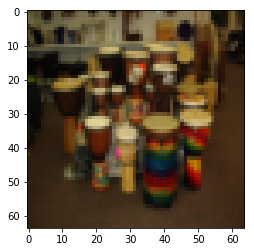

In [21]:
# Example of a picture
index = 5
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [22]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for m_train, m_test and num_px**: 
<table style="width:15%">
  <tr>
    <td>**m_train**</td>
    <td> 209 </td> 
  </tr>
  
  <tr>
    <td>**m_test**</td>
    <td> 50 </td> 
  </tr>
  
  <tr>
    <td>**num_px**</td>
    <td> 64 </td> 
  </tr>
  
</table>


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [23]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**Expected Output**: 

<table style="width:35%">
  <tr>
    <td>**train_set_x_flatten shape**</td>
    <td> (12288, 209)</td> 
  </tr>
  <tr>
    <td>**train_set_y shape**</td>
    <td>(1, 209)</td> 
  </tr>
  <tr>
    <td>**test_set_x_flatten shape**</td>
    <td>(12288, 50)</td> 
  </tr>
  <tr>
    <td>**test_set_y shape**</td>
    <td>(1, 50)</td> 
  </tr>
  <tr>
  <td>**sanity check after reshaping**</td>
  <td>[17 31 56 22 33]</td> 
  </tr>
</table>

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.


![](Images/imvectorkiank.png)


One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [24]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

![](Images/2layerNN_kiank.png)

Now, it's time to learn the weights and make some predictions!

In [28]:
parameters = nn_model(X=train_set_x ,Y=train_set_y, n_h=100, num_iterations=10000, print_error=True)
pred = predict(parameters=parameters, X=test_set_x)
print("Predictions:", pred)

error after iteration 0: 50.710020
error after iteration 100: 46.643908
error after iteration 200: 45.194091
error after iteration 300: 33.946096
error after iteration 400: 30.261280
error after iteration 500: 30.244456
error after iteration 600: 31.063189
error after iteration 700: 25.287562
error after iteration 800: 17.593006
error after iteration 900: 10.266950
[[ 1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.
   0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.
   0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]]


#### How did we do?

Let's try to find out how we did by comparing to the truth:

In [32]:
print("Correct answers:", np.sum(test_set_y == pred))
print("Wrong answers:", np.sum(test_set_y != pred))

Correct answers: 37
Wrong answers: 13


## Further reading

Inspired from this [book](https://www.amazon.com/Make-Your-Own-Neural-Network-ebook/dp/B01EER4Z4G)

And I learned everything that I know from [this course](https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w)